# Results of cat_dog_recognition model

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from tensorflow import keras
import xml.etree.ElementTree as ET
import glob
from PIL import Image
import albumentations as A

# Data loading

In [3]:
NEGATIVE_CLASS = "no-object"
def xml_to_df(path, skipNegatives):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        if root.find('object'):
            for member in root.findall('object'):
                bbx = member.find('bndbox')                
                xmin = round(float(bbx.find('xmin').text))
                ymin = round(float(bbx.find('ymin').text))
                xmax = round(float(bbx.find('xmax').text))
                ymax = round(float(bbx.find('ymax').text))
                label = member.find('name').text
                value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        label,
                        xmin,
                        ymin,
                        xmax,
                        ymax
                        )
                xml_list.append(value)
        elif not skipNegatives:
            value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        NEGATIVE_CLASS,
                        0,
                        0,
                        0,
                        0
                        )
            xml_list.append(value)

    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [4]:
SKIP_NEGATIVES = False
train_full = []
path_xml = os.path.join(os.getcwd(), 'cat_dog_dataset','annotations')
path_images = os.path.join(os.getcwd(), 'cat_dog_dataset','images')
data_df = xml_to_df(path_xml, SKIP_NEGATIVES)

## Loading model

In [5]:
model = keras.models.load_model("cat_dog.h5")

2021-12-02 18:00:11.094022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-02 18:00:11.094434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [6]:
classes = ['cat', 'dog']
images = []
bounding_boxes = []
labels = []
width_height = []
for index,data in data_df.iterrows():
    width = data['width']
    height = data['height']
    if width == 0 or height == 0:
        continue
    path_to_image = os.path.join(path_images, data['filename'])
    image = keras.preprocessing.image.load_img(path_to_image)
    image = keras.preprocessing.image.img_to_array(image)
    image = image/255.
    width_height.append((width, height))
    xmin = data['xmin']
    xmax = data['xmax']
    ymin = data['ymin']
    ymax = data['ymax']
    labels.append(classes.index(data['class']))
    images.append(image)
    bounding_boxes.append((xmin,ymin,xmax,ymax))


In [7]:
def get_scaled_bounding_boxes(xmin,ymin,xmax,ymax,width,height):
    return int(xmin*width), int(ymin*height), int(xmax*width), int(ymax*width)

In [8]:
def plot_image_with_bbox(img, bbox, sizes,label, scaled = False, title = None):
    width, height = sizes
    xmin,ymin,xmax,ymax = bbox
    if scaled == False:
        xmin, ymin, xmax, ymax = get_scaled_bounding_boxes(xmin,ymin,xmax,ymax,width, height)
    pt1=(int(xmin),int(ymin))
    pt2=(int(xmax),int(ymax))
    y = ymin - 10 if ymin - 10 > 10 else ymin + 10
    img_rectangle = cv2.putText(img.copy(), label, (xmin, y), cv2.FONT_HERSHEY_SIMPLEX,
    0.65, (0, 0, 1), 2)
    img_rectangle  = cv2.rectangle(img_rectangle, pt1, pt2, (0,0,1), 4)
    plt.title(title)
    plt.imshow(img_rectangle)

In [9]:
def resize_image(img_arr, bboxes, h, w):
    transform = A.Compose(
        [A.Resize(height=h, width=w, always_apply=True)],
        bbox_params=A.BboxParams(format='pascal_voc'))

    transformed = transform(image=img_arr, bboxes=bboxes)

    return transformed

In [10]:
images = np.array(images)
bounding_boxes = np.array(bounding_boxes)
labels = np.array(labels)
width_height = np.array(width_height)

/var/folders/m1/6g6dzl5508ld58b_7x7xlf4h0000gn/T/ipykernel_35279/1466922968.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


In [11]:
bound_index = int(labels.size*0.8)
test_images = images[bound_index:]
test_labels = labels[bound_index:]
test_bounding_boxes = bounding_boxes[bound_index:]
test_width_height = width_height[bound_index:]

In [12]:
test_images_resized = []
for img in  test_images:
    test_images_resized.append(tf.image.resize(img, [224,224]))
test_images_resized = np.array(test_images_resized)

In [13]:
predictions = []
plot_images = []
plot_width_height = []
plot_bounding_boxes = []
plot_classes = []
plot_scaled = []
plot_titles = []
for i in range(8):
    img = np.expand_dims(test_images_resized[i],0)
    predictions.append(model.predict(img))
    
for i in range(2):
    for j in range(4):
        plot_images.append(test_images[j])
        plot_width_height.append(test_width_height[j])

for i in range(2):
    for j in range(4, 8):
        plot_images.append(test_images[j])
        plot_width_height.append(test_width_height[j])
        
for i in range(4):
    plot_classes.append(classes[test_labels[i]])
    plot_bounding_boxes.append(test_bounding_boxes[i])
    plot_scaled.append(True)
    plot_titles.append("Orginal image")
    
for i in range(4):
    plot_classes.append(classes[np.argmax(predictions[i][0])])
    plot_bounding_boxes.append(predictions[i][1][0])
    plot_scaled.append(False)
    plot_titles.append("prediction")
    
for i in range(4, 8):
    plot_classes.append(classes[test_labels[i]])
    plot_bounding_boxes.append(test_bounding_boxes[i])
    plot_scaled.append(True)
    plot_titles.append("Orginal image")
    
for i in range(4, 8 ):
    plot_classes.append(classes[np.argmax(predictions[i][0])])
    plot_bounding_boxes.append(predictions[i][1][0])
    plot_scaled.append(False)
    plot_titles.append("prediction")
    

2021-12-02 18:00:33.067633: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-02 18:00:33.081931: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-02 18:00:33.228962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


# Results

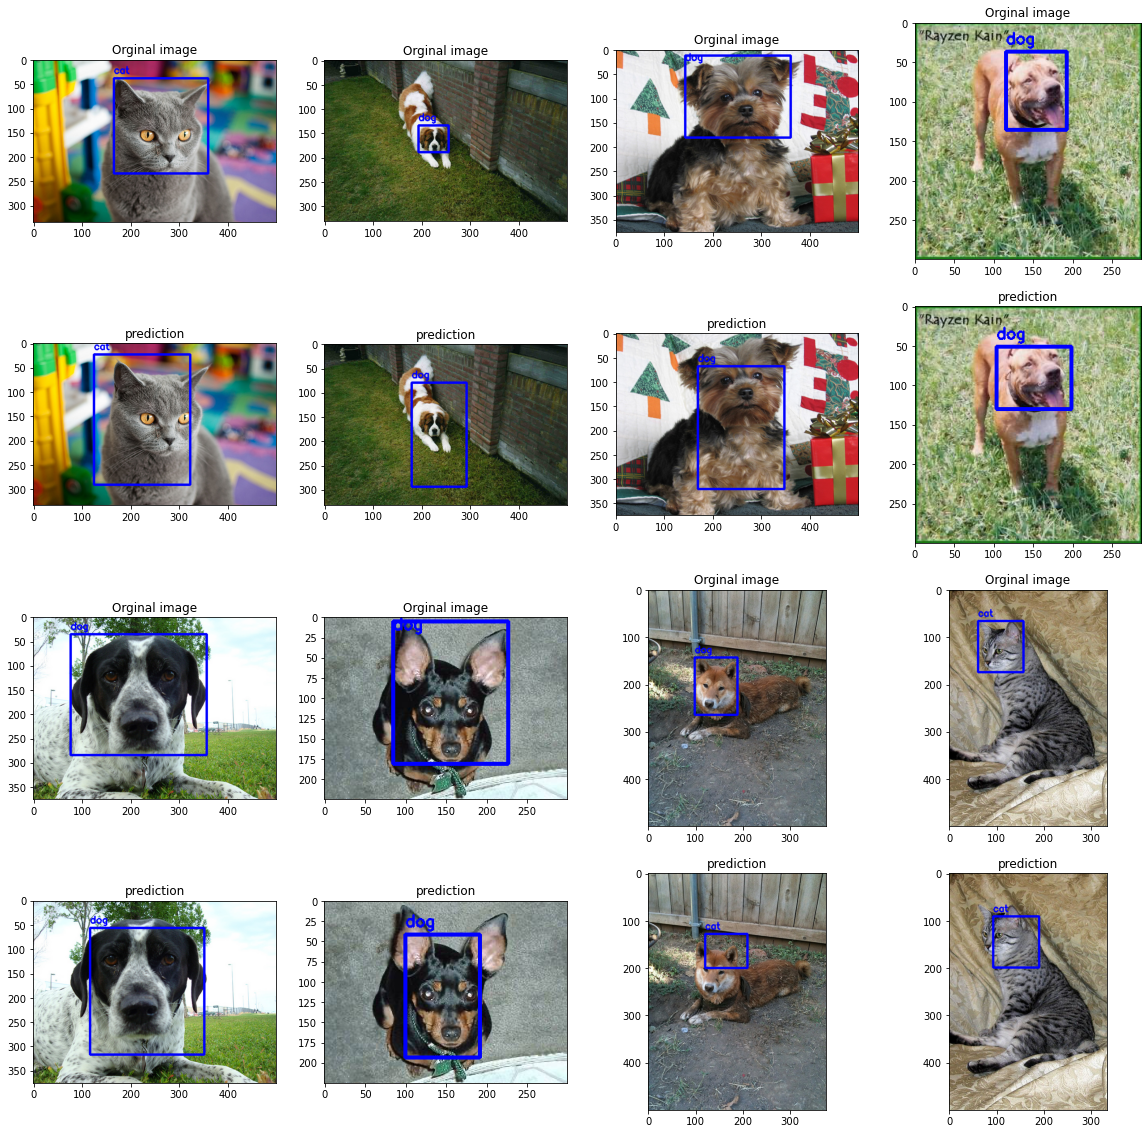

In [14]:
fig = plt.figure(figsize = (20,20))
i = 1
for img, bbox, width_height,class_,scaled,title  in zip(plot_images, plot_bounding_boxes,
                                            plot_width_height, plot_classes, plot_scaled,plot_titles):
    fig.add_subplot(4,4,i)
    plot_image_with_bbox(img, bbox, width_height, class_, scaled,title)
    i+=1